# Tuning Neural Networking in Keras

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Code-along%20Tuning%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

Keras works as weapper for deep learning model to be used as classification or regression estimators in sklearn

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Useful Functions

In [35]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.  
    optional name variable can be used to name each model and/or dataset used 
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

# Data

We will be working with 2 different datasets in this project, 1 is a regression dataset and the other is a classification dataset.  This way you can practice doing both using deep learning.

**NOTE**

These datasets are very small for deep learning.  Deep learning models usually work best with very large datasets with at least 10,000 or more samples.  They work best on even larger datasets than that.  But, for demonstration we will use these smaller datasets.

## Regression
This is a dataset of housing prices in Boston from 1978.  Each row is a house and the dataset includes several features regarding each house.  Our target today will be the price of the home.



In [36]:
regression_df = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/Boston_Housing_from_Sklearn.csv')

# Regression

Let's start with modeling the regression dataset

In [37]:
regression_df

CRIM    NOX     RM   AGE  PTRATIO  LSTAT  PRICE
0    0.00632  0.538  6.575  65.2     15.3   4.98   24.0
1    0.02731  0.469  6.421  78.9     17.8   9.14   21.6
2    0.02729  0.469  7.185  61.1     17.8   4.03   34.7
3    0.03237  0.458  6.998  45.8     18.7   2.94   33.4
4    0.06905  0.458  7.147  54.2     18.7   5.33   36.2
..       ...    ...    ...   ...      ...    ...    ...
501  0.06263  0.573  6.593  69.1     21.0   9.67   22.4
502  0.04527  0.573  6.120  76.7     21.0   9.08   20.6
503  0.06076  0.573  6.976  91.0     21.0   5.64   23.9
504  0.10959  0.573  6.794  89.3     21.0   6.48   22.0
505  0.04741  0.573  6.030  80.8     21.0   7.88   11.9

[506 rows x 7 columns]

In [38]:
regression_df.duplicated().any()

False

In [39]:
regression_df.describe()

CRIM         NOX          RM         AGE     PTRATIO       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524    0.554695    6.284634   68.574901   18.455534   12.653063   
std      8.601545    0.115878    0.702617   28.148861    2.164946    7.141062   
min      0.006320    0.385000    3.561000    2.900000   12.600000    1.730000   
25%      0.082045    0.449000    5.885500   45.025000   17.400000    6.950000   
50%      0.256510    0.538000    6.208500   77.500000   19.050000   11.360000   
75%      3.677083    0.624000    6.623500   94.075000   20.200000   16.955000   
max     88.976200    0.871000    8.780000  100.000000   22.000000   37.970000   

            PRICE  
count  506.000000  
mean    22.532806  
std      9.197104  
min      5.000000  
25%     17.025000  
50%     21.200000  
75%     25.000000  
max     50.000000

In [40]:
# Define X and Y and complete the train test split
X = regression_df.drop(columns = 'PRICE')
y = regression_df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Scaling

Always scale your data for deep learning.  Otherwise you get a problem call 'Exploding Weights'.  Some weights will be updated much faster than others because the inputs are at larger scales.  This tends to hurt learning as data on smaller scales does not update as fast and doesn't get to contribute as much to the decision making process.  By scaling we put all features on the same footing.

In [41]:
# Scale the data
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## First Simple Model

We always want to start simple, as deep learning models can get very complex fast and more complex models take more time to train and are more prone to overfitting.  A well performing simple model is better than a well performing complex model.

## Input layer
The first layer we will define is not technically the input layer.  We will define the first hidden layer with a special argument that tells Keras how to create a input layer:

`input_dim=`

Input layers can also be defined manually using tensorflow.keras.layers.InputLayer

## Activation function

For the single hidden layer we will try just 3 nodes and use a ReLU activation.  ReLUs tend to perform well for hidden nodes.

## Output Layer

For out output layer (last layer) we just use one node because we only want the output of the model to be one number.  We will use a linear activation function.  This will simply output the value from the weights and bias in the node with no change.  The output will be a continuous number, a float.  This will make our model a regression model.




In [42]:
# Check the shape of input

X_train.shape[1]

6

In [43]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model

reg_model1 = Sequential()


# Add first hidden layer
reg_model1.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
reg_model1.add(Dense(10, activation='relu', name='h2'))
# Add output layer with 1 node
reg_model1.add(Dense(1, activation='linear', name ='output'))


# Check summary of network 
reg_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 1000)              7000      
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 h2 (Dense)                  (None, 1000)              1001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 h3 (Dense)                  (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 h4 (Dense)                  (None, 1000)             

## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [44]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [45]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model1.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [46]:
# Fit your model

history = reg_model1.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
12/12 [==============================] - 1s 20ms/step - loss: 637.9359 - mae: 23.4772 - rmse: 25.2574 - val_loss: 545.4328 - val_mae: 21.8478 - val_rmse: 23.3545
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 627.7352 - mae: 23.2455 - rmse: 25.0546 - val_loss: 536.6983 - val_mae: 21.6346 - val_rmse: 23.1667
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 619.5906 - mae: 23.0577 - rmse: 24.8916 - val_loss: 530.1472 - val_mae: 21.4729 - val_rmse: 23.0249
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 613.4155 - mae: 22.9153 - rmse: 24.7672 - val_loss: 525.1700 - val_mae: 21.3489 - val_rmse: 22.9166
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 608.6854 - mae: 22.8067 - rmse: 24.6716 - val_loss: 521.3907 - val_mae: 21.2550 - val_rmse: 22.8340
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 604.8336 - mae: 22.7205 - rmse: 24.5934 - val_loss: 518.1628 

Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 32.5093 - mae: 4.0443 - rmse: 5.7017 - val_loss: 31.6458 - val_mae: 3.8778 - val_rmse: 5.6255
Epoch 98/100
12/12 [==============================] - 0s 3ms/step - loss: 32.1349 - mae: 4.0166 - rmse: 5.6688 - val_loss: 31.3192 - val_mae: 3.8200 - val_rmse: 5.5964
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 31.9491 - mae: 4.0019 - rmse: 5.6524 - val_loss: 31.2125 - val_mae: 3.8294 - val_rmse: 5.5868
Epoch 100/100
12/12 [==============================] - 0s 3ms/step - loss: 31.6734 - mae: 3.9582 - rmse: 5.6279 - val_loss: 30.9834 - val_mae: 3.7755 - val_rmse: 5.5663


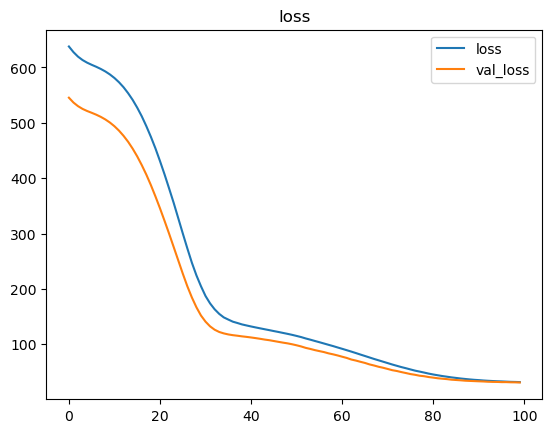

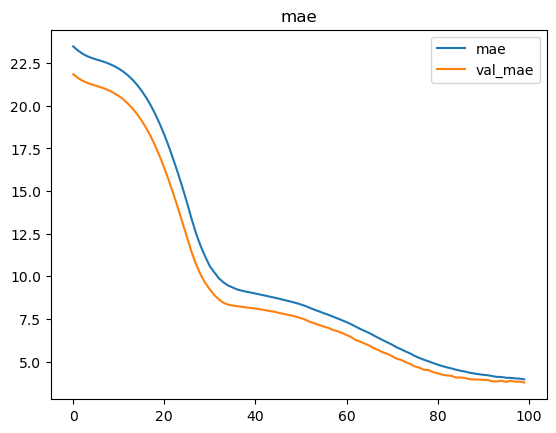

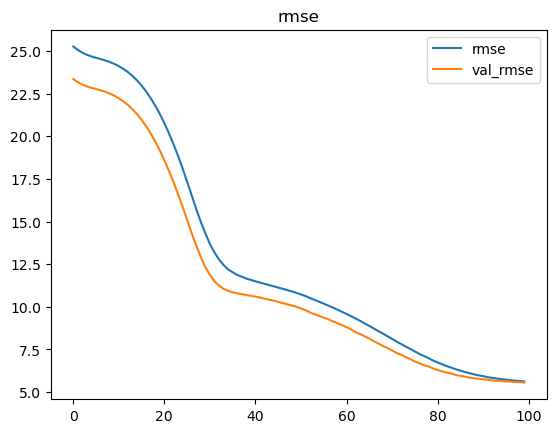

In [47]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [48]:
train_scores = eval_regression(reg_model1, 
                         X_train, 
                         y_train, 
                         name='reg_model1 Train')
test_scores = eval_regression(reg_model1, 
                                       X_test, 
                                       y_test, 
                                       name='reg_model1 test')
scores = pd.concat([train_scores, test_scores])
scores

4/4 [==============================] - 0s 997us/step


MAE      RMSE        R2
reg_model1 Train  3.941398  5.606805  0.645516
reg_model1 test   3.775498  5.566272  0.557552

# <center> Attack Bias or Variance? </center>

How should we tune this regression model?

In [49]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate your sequential model

reg_model2 = Sequential()
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Add first hidden layer
reg_model2.add(Dense(100, activation='relu', input_dim=input_dim, name='h1'))
reg_model2.add(Dense(100, activation='relu', name='h2'))
# Add output layer with 1 node
reg_model2.add(Dense(1, activation='linear', name ='output'))


# Check summary of network 
reg_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               700       
                                                                 
 h2 (Dense)                  (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [50]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model2.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [51]:
# Fit your model

history = reg_model2.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 593.5229 - mae: 22.4639 - rmse: 24.3623 - val_loss: 490.8051 - val_mae: 20.4753 - val_rmse: 22.1541
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 552.0474 - mae: 21.4749 - rmse: 23.4957 - val_loss: 445.5287 - val_mae: 19.2671 - val_rmse: 21.1076
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 491.6236 - mae: 19.9239 - rmse: 22.1726 - val_loss: 374.9682 - val_mae: 17.2202 - val_rmse: 19.3641
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 399.4338 - mae: 17.3062 - rmse: 19.9858 - val_loss: 274.4481 - val_mae: 13.9321 - val_rmse: 16.5665
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 279.7343 - mae: 13.6299 - rmse: 16.7253 - val_loss: 171.1440 - val_mae: 10.2977 - val_rmse: 13.0822
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 177.9235 - mae: 10.5157 - rmse: 13.3388 - val_loss: 122.0163 

Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 18.4761 - mae: 2.9381 - rmse: 4.2984 - val_loss: 18.0399 - val_mae: 2.7190 - val_rmse: 4.2473
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 18.7511 - mae: 2.9983 - rmse: 4.3303 - val_loss: 18.0724 - val_mae: 2.7047 - val_rmse: 4.2512
Epoch 100/100
12/12 [==============================] - 0s 4ms/step - loss: 18.5854 - mae: 2.9253 - rmse: 4.3111 - val_loss: 17.8739 - val_mae: 2.7278 - val_rmse: 4.2278


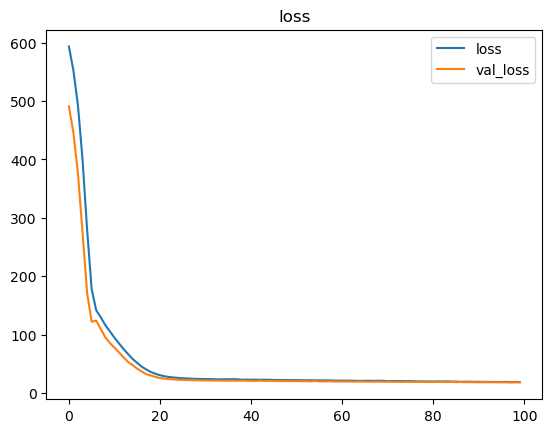

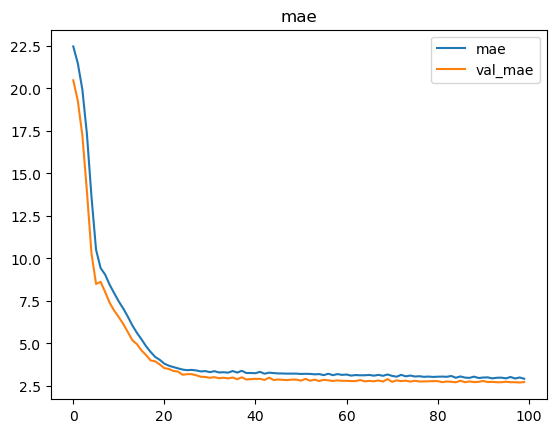

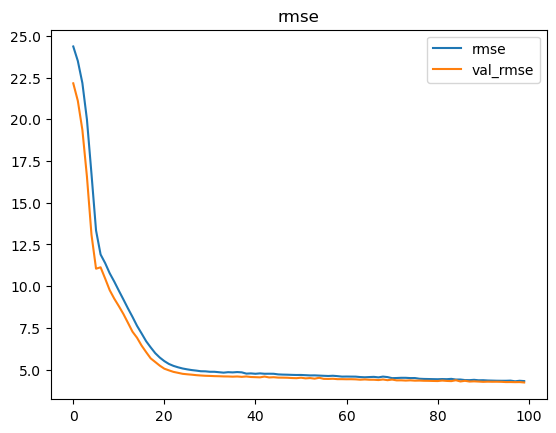

In [52]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [53]:
train_scores = eval_regression(reg_model2, 
                         X_train, 
                         y_train, 
                         name='reg_model2 Train')
test_scores = eval_regression(reg_model2, 
                                       X_test, 
                                       y_test, 
                                       name='reg_model2 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

4/4 [==============================] - 0s 997us/step


MAE      RMSE        R2
reg_model1 Train  3.941398  5.606805  0.645516
reg_model1 test   3.775498  5.566272  0.557552
reg_model2 Train  2.945042  4.275885  0.793834
reg_model2 test   2.727790  4.227755  0.744757

In [54]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Instantiate your sequential model

reg_model3 = Sequential()
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Add first hidden layer
reg_model3.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
reg_model3.add(Dense(10, activation='relu', name='h2'))
reg_model3.add(Dense(10, activation='relu', name='h3'))
reg_model3.add(Dense(10, activation='relu', name='h4'))

# Add output layer with 1 node
reg_model3.add(Dense(1, activation='linear', name ='output'))


# Check summary of network 
reg_model3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                70        
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 h3 (Dense)                  (None, 10)                110       
                                                                 
 h4 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [55]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model3.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [56]:
# Fit your model

history = reg_model3.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 603.7324 - mae: 22.7049 - rmse: 24.5710 - val_loss: 514.8127 - val_mae: 21.0927 - val_rmse: 22.6895
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 594.2388 - mae: 22.4856 - rmse: 24.3770 - val_loss: 505.2496 - val_mae: 20.8484 - val_rmse: 22.4778
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 583.3914 - mae: 22.2264 - rmse: 24.1535 - val_loss: 493.5770 - val_mae: 20.5514 - val_rmse: 22.2166
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 569.1133 - mae: 21.8853 - rmse: 23.8561 - val_loss: 477.2758 - val_mae: 20.1314 - val_rmse: 21.8466
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 548.8754 - mae: 21.3975 - rmse: 23.4281 - val_loss: 454.6926 - val_mae: 19.5310 - val_rmse: 21.3235
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 520.2674 - mae: 20.6840 - rmse: 22.8094 - val_loss: 422.8167 

Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 22.1735 - mae: 3.2292 - rmse: 4.7089 - val_loss: 20.1219 - val_mae: 2.8213 - val_rmse: 4.4857
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 22.4513 - mae: 3.2739 - rmse: 4.7383 - val_loss: 20.0117 - val_mae: 2.8405 - val_rmse: 4.4734
Epoch 100/100
12/12 [==============================] - 0s 3ms/step - loss: 22.3702 - mae: 3.2144 - rmse: 4.7297 - val_loss: 20.0579 - val_mae: 2.8177 - val_rmse: 4.4786


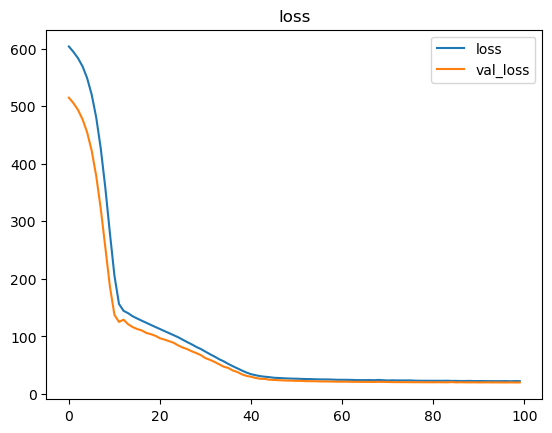

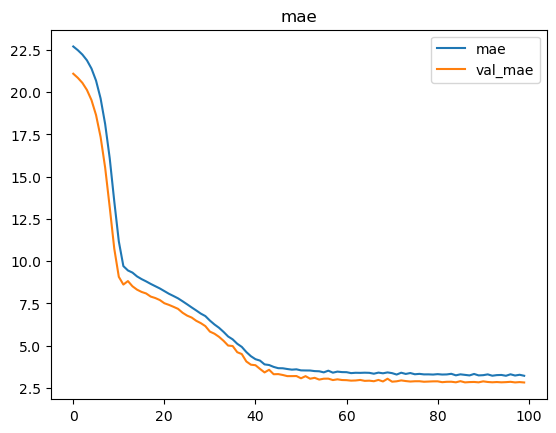

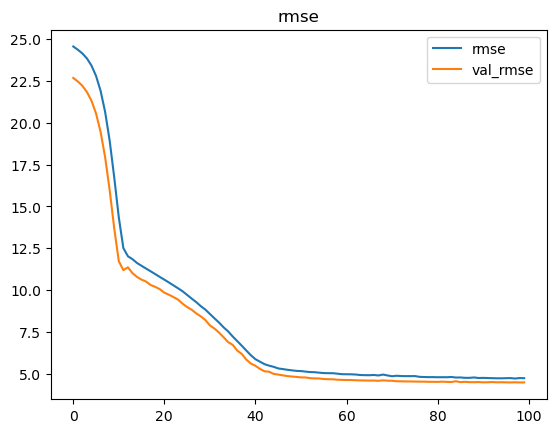

In [57]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [58]:
train_scores = eval_regression(reg_model3, 
                         X_train, 
                         y_train, 
                         name='reg_model3 Train')
test_scores = eval_regression(reg_model3, 
                                       X_test, 
                                       y_test, 
                                       name='reg_model3 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

4/4 [==============================] - 0s 2ms/step


MAE      RMSE        R2
reg_model1 Train  3.941398  5.606805  0.645516
reg_model1 test   3.775498  5.566272  0.557552
reg_model2 Train  2.945042  4.275885  0.793834
reg_model2 test   2.727790  4.227755  0.744757
reg_model3 Train  3.211658  4.691137  0.751846
reg_model3 test   2.817708  4.478599  0.713570